<a href="https://colab.research.google.com/github/EsraaMosaad/Practice_NLP/blob/main/text_clssification_spamORharm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ***practice*** **Using BERT and Tensorflow 2.0, we will write simple code to classify emails as spam or not spam. BERT will be used to generate sentence encoding for all emails and after that we will use a simple neural network with one drop out layer and one output layer.I've been using this YouTube Tutorial Channel https://www.youtube.com/watch?v=hOCDJyZ6quA**

In [8]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
!cp /content/drive/MyDrive/kaggel_api/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


In [10]:
!kaggle datasets download -d arunasivapragasam/spam-or-ham
! unzip /content/spam-or-ham.zip

100% 209k/209k [00:00<00:00, 427kB/s]
100% 209k/209k [00:00<00:00, 427kB/s]
Archive:  /content/spam-or-ham.zip
  inflating: SMSCollection.csv       


In [11]:
import pandas as pd
import tensorflow as tf
import numpy as np


# **data preprossing** spam & ham sms

In [12]:
df=pd.read_csv("/content/SMSCollection.csv")

In [13]:
df

,Class,sms
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [14]:
df.groupby('Class').describe()

sms                                                               
      count unique                                                top freq
Class                                                                     
ham    4825   4516                             Sorry, I'll call later   30
spam    747    653  Please call our customer service representativ...    4

In [15]:
df['Class'].value_counts()

ham     4825
spam     747
Name: Class, dtype: int64

Balance data

In [16]:
df_spam=df[df['Class']=='spam']
df_spam.shape

(747, 2)

In [17]:
df_ham=df[df['Class']=='ham']
df_ham.shape

(4825, 2)

In [18]:
df_resampling=df_ham.sample(df_spam.shape[0])
df_resampling.shape

(747, 2)

In [19]:
balance_df=pd.concat([df_resampling,df_spam])
balance_df.shape

(1494, 2)

In [20]:
balance_df.groupby(["Class"]).describe()

sms                                                               
      count unique                                                top freq
Class                                                                     
ham     747    736                                              Ok...    3
spam    747    653  Please call our customer service representativ...    4

convert spam to numeric by adding nwe colum to data frame 

In [21]:
balance_df['spam']=balance_df['Class'].apply(lambda x: 1 if x=='spam' else 0)
balance_df.head(10)

,Class,sms,spam
3836,ham,I'm thinking that chennai forgot to come for a...,0
4707,ham,Wow so healthy. Old airport rd lor. Cant thk o...,0
2401,ham,Hi! This is Roger from CL. How are you?,0
1644,ham,U WILL SWITCH YOUR FONE ON DAMMIT!!,0
1327,ham,"Sorry, was in the bathroom, sup",0
2190,ham,Yup i shd haf ard 10 pages if i add figures......,0
260,ham,I‘m parked next to a MINI!!!! When are you com...,0
3699,ham,S:)but he had some luck.2 catches put down:),0
4817,ham,Anything is valuable in only 2 situations: Fir...,0
1337,ham,"Sweet, we may or may not go to 4U to meet carl...",0


In [22]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(balance_df['sms'], balance_df['spam'],stratify=balance_df['spam'])


In [23]:
x_train.head(4)

4748    When you just put in the + sign, choose my num...
3639    Customer service announcement. We recently tri...
4284    Science tells that chocolate will melt under t...
3859                               R u still working now?
Name: sms, dtype: object

# **BERT_MODEL**

In [24]:
!pip install -q -U "tensorflow-text==2.8.*"

In [25]:
import tensorflow_hub as hub
import tensorflow_text as text

In [26]:
preprocess_url='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
encoder_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [27]:
BERT_preprocess_model=hub.KerasLayer(preprocess_url)
BERT_encoder=hub.KerasLayer(encoder_url)

In [28]:
def get_sentance_embeding(x):
  text_preprocessed=BERT_preprocess_model(x)
  BERT_result=BERT_encoder(text_preprocessed)
  print(len(BERT_result))
  return BERT_result['pooled_output']

In [29]:
embedding=get_sentance_embeding(['banana',"orange",'mango','bill gates','elon musk'])

4


In [30]:
embedding[0].shape

TensorShape([768])

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([embedding[3]],[embedding[4]])

array([[0.9164155]], dtype=float32)

In [32]:
#BERT layer
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string ,name="text")
preprocessed_text=BERT_preprocess_model(text_input)
outputs=BERT_encoder(preprocessed_text)
#Neural network layers

l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)
# construct final model
model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [34]:
METRICS=[
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [35]:
model.fit(x_train,y_train,epochs=10)

Epoch 1/10
35/35 [==============================] - 23s 369ms/step - loss: 0.5998 - accuracy: 0.7054 - precision: 0.7076 - recall: 0.7000
Epoch 2/10
35/35 [==============================] - 11s 321ms/step - loss: 0.4794 - accuracy: 0.8429 - precision: 0.8200 - recall: 0.8786
Epoch 3/10
35/35 [==============================] - 11s 312ms/step - loss: 0.4190 - accuracy: 0.8571 - precision: 0.8497 - recall: 0.8679
Epoch 4/10
35/35 [==============================] - 11s 314ms/step - loss: 0.3745 - accuracy: 0.8857 - precision: 0.8711 - recall: 0.9054
Epoch 5/10
35/35 [==============================] - 11s 313ms/step - loss: 0.3440 - accuracy: 0.8795 - precision: 0.8657 - recall: 0.8982
Epoch 6/10
35/35 [==============================] - 11s 315ms/step - loss: 0.3214 - accuracy: 0.8991 - precision: 0.8834 - recall: 0.9196
Epoch 7/10
35/35 [==============================] - 12s 347ms/step - loss: 0.3108 - accuracy: 0.8938 - precision: 0.8808 - recall: 0.9107
Epoch 8/10
35/35 [================

In [36]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 5s 309ms/step - loss: 0.2540 - accuracy: 0.9278 - precision: 0.9255 - recall: 0.9305


[0.25395911931991577,
 0.9278075098991394,
 0.9255319237709045,
 0.9304812550544739]

In [37]:
y_pred=model.predict(x_test)
y_pred=y_pred.flatten()

In [38]:
y_pred=np.where(y_pred>0.5,1,0)

In [39]:
from  sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)
cm

array([[173,  14],
       [ 13, 174]])

Text(33.0, 0.5, 'Truth')

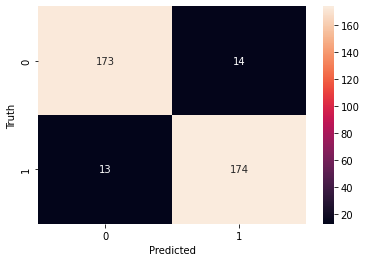

In [40]:
from matplotlib import pyplot as plt 
import seaborn as sn
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')